In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
import statsmodels.api as sm
import math
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

In [2]:
prs_output = '/Users/jerenolsen/Desktop/All_Tests/PRSice_Testing/Test_Run/PRS_output/cohort_prs.best'
df_prs = pd.read_csv(prs_output, sep=' ')

In [3]:
cohort_info = '/Users/jerenolsen/Desktop/All_Tests/PRSice_Testing/Test_Run/PRS_output/prs_cohort_info.csv'
df_ci = pd.read_csv(cohort_info, sep ='\t')

In [4]:
merged = df_prs.merge(df_ci, left_on = 'FID', right_on = 'profile_id')

In [5]:
# Standardize scores

In [6]:
# Extract PRS values
prs_values = merged['PRS'].values.reshape(-1, 1)  # Reshape to a 2D array

# Standardize PRS values
scaler = StandardScaler()
standardized_prs = scaler.fit_transform(prs_values)

# Update the DataFrame with standardized PRS values
merged['Standardized_PRS'] = standardized_prs

In [7]:
merged

,FID,IID,In_Regression,PRS,Unnamed: 0,profile_id,affected_status,gender,Standardized_PRS
0,hu002B3C,hu002B3C,Yes,-0.000029,54,hu002B3C,control,Male,-0.363854
1,hu005023,hu005023,Yes,-0.000029,97,hu005023,control,Female,-0.929254
2,hu011C57,hu011C57,Yes,-0.000029,52,hu011C57,case,Male,-0.223479
3,hu016B28,hu016B28,Yes,-0.000029,0,hu016B28,case,Male,-0.328692
4,hu0199C8,hu0199C8,Yes,-0.000029,81,hu0199C8,control,Male,-0.429737
...,...,...,...,...,...,...,...,...,...
188,hu9D00EB,hu9D00EB,Yes,-0.000028,93,hu9D00EB,case,Male,0.576236
189,huA49E22,huA49E22,Yes,-0.000029,50,huA49E22,case,Male,-0.793789
190,huAA245C,huAA245C,Yes,-0.000029,42,huAA245C,case,Female,-0.577284
191,huB4940E,huB4940E,Yes,-0.000028,43,huB4940E,case,Male,0.477329


In [17]:
def create_double_distribution(case_data, control_data, x_name='PRS'):
    
    fig, ax = plt.subplots()

    # Plot the cases and controls distributions
    sns.kdeplot(data=case_data, x=x_name, ax=ax, label='Cases', color='red', fill=True, alpha=0.35)
    sns.kdeplot(data=control_data, x=x_name, ax=ax, label='Controls',linestyle='solid', color='blue', fill=True, alpha=0.2)
    
    mean_cases = np.mean(case_data[x_name])
    mean_controls = np.mean(control_data[x_name])

    # Plot vertical lines at PRS means
    ax.axvline(mean_cases, color='red', linestyle='dotted', label='Cases Mean', linewidth=1)
    ax.axvline(mean_controls, color='blue', linestyle='dotted', label='Controls Mean', linewidth=1)
    
    ax.set_title("Distribution Plot of GERD Polygenic Risk Scores for Cases and Controls")

    ax.legend()
    plt.show()
    
    return True

def perform_ttest(prs_data, status_col_name, case_label, control_label, score_col_name):
    # Split the data into cases and controls
    cases_data = prs_data[prs_data[status_col_name] == case_label]
    controls_data = prs_data[prs_data[status_col_name] ==  control_label]

    # Perform the t-test for independent samples
    t_stat, p_value = ttest_ind(cases_data[score_col_name], controls_data[score_col_name])

    print("T-statistic:", round(t_stat, 2))
    print("P-value:", round(p_value, 4))
    
    return True

def generate_regplot(prs_data, status_col_name, case_label, control_label, score_col_name):
    warnings.filterwarnings('ignore')
    status_mapping = {control_label: 0, case_label: 1}

    # Map affected_status to binary values
    prs_data['affected_status_numeric'] = prs_data[status_col_name].map(status_mapping)

    # Create the logistic regression plot with curve
    sns.lmplot(data=prs_data, x= score_col_name, y='affected_status_numeric', logistic=True, markers=['o', 'x'], hue='affected_status')
    sns.regplot(data=prs_data, x= score_col_name, y='affected_status_numeric', logistic=True, scatter=False, ci=None)


    plt.xlabel(score_col_name)
    plt.ylabel('Affected Status (0=Control, 1=Case)')
    plt.title('Association between PRS and GERD Phenotype')
    plt.show()
    
    return True

def generate_regplot2(prs_data, status_col_name, case_label, control_label, score_col_name):
    warnings.filterwarnings('ignore')
    status_mapping = {control_label: 0, case_label: 1}

    # Map affected_status to binary values
    prs_data['affected_status_numeric'] = prs_data[status_col_name].map(status_mapping)

    # Create the logistic regression plot with curve and confidence intervals
    sns.lmplot(data=prs_data, x=score_col_name, y='affected_status_numeric', logistic=True, markers=['o', 'x'], hue='affected_status')
    sns.regplot(data=prs_data, x=score_col_name, y='affected_status_numeric', logistic=True, scatter=False, ci=95)  # Set ci=95 for 95% confidence intervals

    plt.xlabel(score_col_name)
    plt.ylabel('Affected Status (0=Control, 1=Case)')
    plt.title('Association between PRS and GERD Phenotype')
    plt.show()
    
    return True

def perform_max_odds_ratio(prs_data, score_column_name, affected_column_name, case_label = 'case'):
    
    prs_values = prs_data[score_column_name].unique()
    max_odds_ratio = 0.0
    associated_p = 0

    for prs_value in prs_values:
        # Create a 2x2 contingency table
        contingency_table = pd.crosstab(prs_data[score_column_name] > prs_value, prs_data[affected_column_name] == case_label)

        # Perform the chi-square test and get the odds ratio
        odds_ratio, p_value, _, _ = stats.chi2_contingency(contingency_table)

        # Update the maximum odds ratio
        if odds_ratio > max_odds_ratio:
            max_odds_ratio = odds_ratio
            associated_p = p_value

    print("Maximum Odds Ratio:", round(max_odds_ratio,2))
    print("Associated P Value:", round(associated_p,4))
    
    return True

def perform_max_odds_ratio2(prs_data, score_column_name, affected_column_name, case_label='case'):
    prs_data['intercept'] = 1
    X = prs_data[[score_column_name, 'intercept']]
    y = prs_data[affected_column_name] == case_label

    model = sm.Logit(y, X)
    result = model.fit()

    max_odds_ratio = round(result.params[score_column_name], 2)
    associated_p = round(result.pvalues[score_column_name], 4)

    print("Maximum Odds Ratio:", max_odds_ratio)
    print("Associated P Value:", associated_p)

    return True


In [21]:
cases = merged[merged['affected_status'] == 'case']
controls = merged[merged['affected_status'] == 'control']

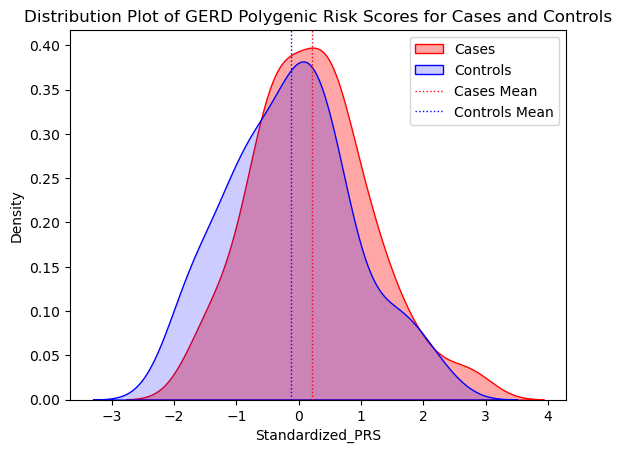

True

In [22]:
create_double_distribution(cases, controls,  x_name = 'Standardized_PRS')

In [50]:
std

1.001951221367587

In [17]:
perform_ttest(prs_data=merged, status_col_name='affected_status', case_label='case', control_label='control', score_col_name='Standardized_PRS')

T-statistic: 2.66
P-value: 0.0082


True

In [59]:
data = [
    ['Mean PRS Cases', 0.217],
    ['Mean PRS Controls', -0.125],
    ['T-statistic', 2.66],
    ['P-value', 0.0082]
]
print(tabulate(data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒═══════════════════╤═════════╕
│ Metric            │   Value │
╞═══════════════════╪═════════╡
│ Mean PRS Cases    │  0.217  │
├───────────────────┼─────────┤
│ Mean PRS Controls │ -0.125  │
├───────────────────┼─────────┤
│ T-statistic       │  2.66   │
├───────────────────┼─────────┤
│ P-value           │  0.0082 │
╘═══════════════════╧═════════╛


# Logistic Regression

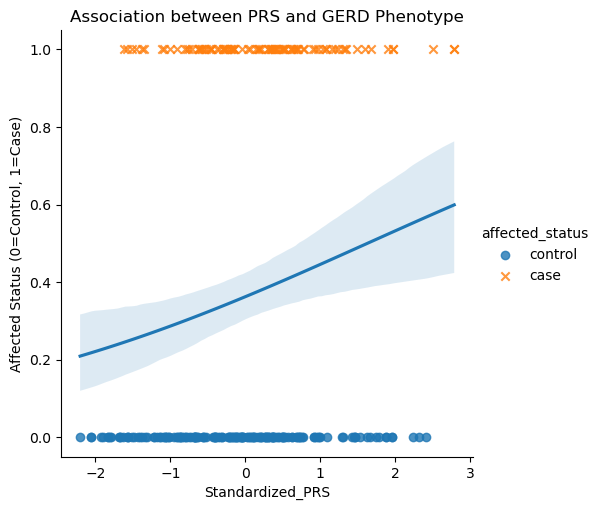

True

In [19]:
generate_regplot2(prs_data=merged, status_col_name='affected_status', case_label='case', control_label='control', score_col_name='Standardized_PRS')

In [20]:
data = pd.get_dummies(merged, columns=["affected_status", "gender"], drop_first=True)

# Default newton method

In [28]:
# Define the dependent variable (target)
target = "affected_status_numeric"

# Define the independent variables (predictors)
predictors = ["Standardized_PRS"]

# Add a constant term for the intercept
data["intercept"] = 1

# Create the logistic regression model
logit_model = sm.Logit(data[target], data[predictors + ["intercept"]])

# Fit the model
method="newton"
result = logit_model.fit(maxiter=10000)
#result = logit_model.fit(method="newton")

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.643047
         Iterations 5
                              Logit Regression Results                             
Dep. Variable:     affected_status_numeric   No. Observations:                  257
Model:                               Logit   Df Residuals:                      255
Method:                                MLE   Df Model:                            1
Date:                     Sun, 13 Aug 2023   Pseudo R-squ.:                 0.02073
Time:                             15:16:09   Log-Likelihood:                -165.26
converged:                            True   LL-Null:                       -168.76
Covariance Type:                 nonrobust   LLR p-value:                  0.008164
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Standardized_PRS     0.3470      0.133      2.602      0

- Pseudo R-squared is 0.02073, indicating that the model explains around 2.07% of the variability in the affected_status_numeric variable. Quite poor.
- LL vs LLN: How well the given model fits the data vs. LL fit of a model with no predictors (baseline). Small difference.
- LLR p-value indicates significant improvement over null model.


- coefficiet: estimated change in the log-odds of being in the "affected" category for a one-unit increase in the standardized PRS
- Smaller standard error implies more confidence in estimates
- z score - ceof/std_err = how many standard deviations the coef estimate is away from 0
- Significance of coef estimate
- Confidence intervals, range in which the true population parameter is likely to lie in

# Predictive Modelling

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve, RocCurveDisplay
from yellowbrick.classifier import ROCAUC

In [36]:
ml_df = merged[['FID','Standardized_PRS', 'gender', 'affected_status_numeric']]
ml_df.rename(columns = {'Standardized_PRS':'PRS'}, inplace=True)

In [37]:
ml_df

,FID,PRS,gender,affected_status_numeric
0,hu002B3C,-0.333249,Male,0
1,hu005023,-0.915900,Female,0
2,hu011C57,-0.188591,Male,1
3,hu016B28,-0.297014,Male,1
4,hu0199C8,-0.401142,Male,0
...,...,...,...,...
252,huEBD467,-1.143442,Male,0
253,huF160AA,0.520218,Male,0
254,huF45021,1.458360,Female,0
255,huF5AD12,1.954142,Male,0


# Note About ROC AUC Curve

Micro Average ROC Curve AUC:
The micro average AUC-ROC is calculated by considering all the individual instances (samples) and their corresponding true positive and false positive counts across all classes. In the micro-average, the TPR and FPR are computed by pooling the true positive and false positive counts of all classes together. It treats all samples equally and gives more weight to larger classes.

Macro Average ROC Curve AUC:
The macro average AUC-ROC is calculated by averaging the AUC-ROC values for each class. It treats each class equally, regardless of the class's size. First, you calculate the AUC-ROC for each class separately, and then you average those values to get the macro average AUC-ROC.

# Train / Validate / Test

In [51]:
data = ml_df

Best Hyperparameters: {'C': 5, 'penalty': 'l2'}
Accuracy: 0.6410256410256411

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.96      0.77        24
           1       0.67      0.13      0.22        15

    accuracy                           0.64        39
   macro avg       0.65      0.55      0.49        39
weighted avg       0.65      0.64      0.56        39


Confusion Matrix:
 [[23  1]
 [13  2]]


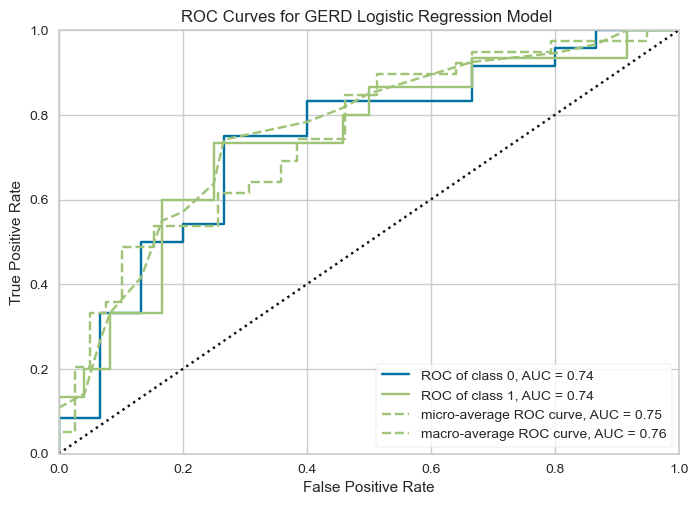

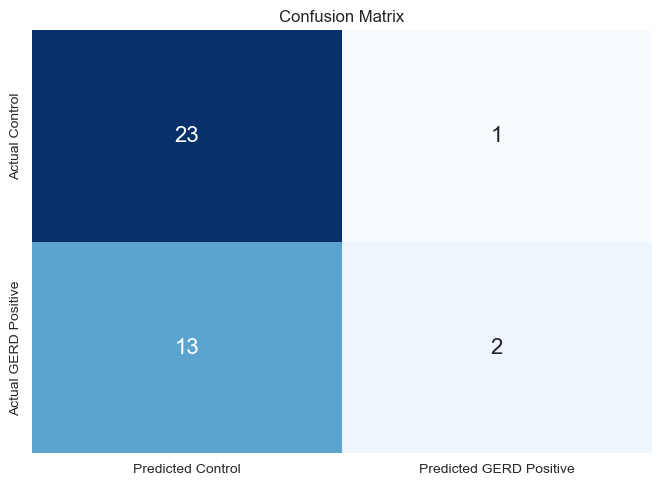

Feature Importance Coefficients:
  Feature  Coefficient
0     PRS     0.307636
1  gender    -0.779560


In [55]:
# Step 1: Preprocess the Data
# Select the relevant features and labels
X = data[['PRS', 'gender']]
y = data['affected_status_numeric']

# Encode categorical variables (gender)
encoder = LabelEncoder()
X['gender'] = encoder.fit_transform(X['gender'])

# Step 2: Split the Data into train/validation/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Train the Model
# Apply feature scaling to PRS scores 
scaler = StandardScaler()
X_train[['PRS']] = scaler.fit_transform(X_train[['PRS']])
X_val[['PRS']] = scaler.transform(X_val[['PRS']])
X_test[['PRS']] = scaler.transform(X_test[['PRS']])

# Step 4: Hyperparameter Tuning using GridSearchCV on the validation set
param_grid = {'C': [0.1, 0.5, 1, 2, 5, 10, 15, 25, 35, 50], 'penalty': ['l1', 'l2']}
logreg_model = LogisticRegression()
grid_search = GridSearchCV(logreg_model, param_grid, cv=3)
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_

# Input best hyperparameters into new model
logreg_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'])

# Train the final model on the whole training set
logreg_model.fit(X_train, y_train)

# Step 5: Evaluate the Model on the Test Data
y_pred = logreg_model.predict(X_test)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 6: Fit the ROCAUC Visualizer with the tuned model
visualizer = ROCAUC(logreg_model, title="ROC Curves for GERD Logistic Regression Model ")
visualizer.fit(X_train, y_train)

# Step 7: ROC Curve
visualizer.score(X_test, y_test)
visualizer.show()

# Step 8: Extract the most important features
coefficients = logreg_model.coef_[0]

# Map labels in the confusion matrix
conf_matrix_labeled = pd.DataFrame(conf_matrix, columns=['Predicted Control', 'Predicted GERD Positive'],
                                   index=['Actual Control', 'Actual GERD Positive'])

# Display the confusion matrix as a heat plot
sns.heatmap(conf_matrix_labeled, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.show()

# Map the coefficients back to the original feature names
feature_names = X.columns
importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance = importance.sort_values(by='Coefficient', ascending=False)

print("Feature Importance Coefficients:")
print(importance)

In [14]:
accuracy = 0.6410256410256411
classification_rep = """
               precision    recall  f1-score   support
           Control       0.63      1.00      0.77        24
           Case       1.00      0.07      0.12        15
        
"""
classification_rep = """               precision    recall  f1-score   support

           Control       0.64      0.96      0.77        24
           Case       0.67      0.13      0.22        15"""


# Display the accuracy
print("Accuracy:", round(accuracy,2))

# Display the classification report as a tabulated table
classification_report_table = tabulate(
    [row.split() for row in classification_rep.split('\n') if row.strip()],
    headers='firstrow',
    tablefmt='fancy_grid'
)
print("\nClassification Report:")
print(classification_report_table)

Accuracy: 0.64

Classification Report:
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│         │   precision │   recall │   f1-score │   support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Control │        0.64 │     0.96 │       0.77 │        24 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ Case    │        0.67 │     0.13 │       0.22 │        15 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛
